In [1]:
# import dependencies
%cd c:/Users/gkstk/Capstone/
import argparse
import math
import time
from pathlib import Path
import cv2
import torch
import numpy as np
import torch.backends.cudnn as cudnn
from numpy import random
from tqdm.auto import tqdm

# SORT Import
from sort import * # sort.py yolov7 폴더, sort.py 내부 matplotlib.use('TKAgg') 지우기

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized, TracedModel

# ZoeDepth Import
from torchvision import transforms
from zoedepth.utils.misc import save_raw_16bit, colorize
from PIL import Image, ImageTk
import matplotlib.pyplot as plt

# BSUVNet Import
import sys
import configs.infer_config_autoBG as cfg
from utils.data_loader import videoLoader

# GUI Import
import tkinter as tk
import tkinter.ttk as ttk
import tkinter.font as font

def letterbox(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)

def draw_boxes(img, bbox, identities=None, categories=None, confidences = None, names=None, colors = None):
    for i, box in enumerate(bbox):
        x1, y1, x2, y2 = [int(i) for i in box]
        tl = opt['thickness'] or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness

        cat = int(categories[i]) if categories is not None else 0
        id = int(identities[i]) if identities is not None else 0
        # conf = confidences[i] if confidences is not None else 0

        color = colors[cat]
        
        if not opt['nobbox']:
            cv2.rectangle(img, (x1, y1), (x2, y2), color, tl)

        if not opt['nolabel']:
            label = str(id) + ":"+ names[cat] if identities is not None else  f'{names[cat]} {confidences[i]:.2f}'
            tf = max(tl - 1, 1)  # font thickness
            t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
            c2 = x1 + t_size[0], y1 - t_size[1] - 3
            cv2.rectangle(img, (x1, y1), c2, color, -1, cv2.LINE_AA)  # filled
            cv2.putText(img, label, (x1, y1 - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

    return img 

def crop_img(img, bbox, type='edgepoint'):
  """
    img(numpy.ndarray) : shape = [H, W, C] 
    bbox(numpy.ndarray) : shape = 'type' midpoint : [X, Y, W, H] or edgepoint : [X1, Y1, X2, Y2]

  """
  if isinstance(img, torch.Tensor):
        img = img.detach().cpu().numpy()
  if isinstance(bbox, torch.Tensor):
        bbox = bbox.detach().cpu().numpy()

  if type == 'edgepoint':
    x_left = int(bbox[0])
    y_left = int(bbox[1])
    x_right = int(bbox[2])
    y_right = int(bbox[3])

    cropped_img = img[y_left:y_right, x_left:x_right, :]

  else: # for [X, Y, H, W]
    x_left = int(bbox[0] - bbox[2] / 2)
    y_left = int(bbox[1] - bbox[3] / 2)
    x_right = int(bbox[0] + bbox[2] / 2)
    y_right = int(bbox[1] + bbox[3] / 2)
    cropped_img = img[y_left:y_right, x_left:x_right, :]
  
  return cropped_img

def get_grad(track, img0, thickness, sep=1, rate=5, gap=5, line_len=50, draw_lines=False): # sep : 간격, rate : accumulation rate
    epsil = 1e-7
    grad = 0
    direc = None
    pix_len = 0

    if len(track.centroidarr) - sep * rate - gap - 1 >= 0:
        track.centroidarr = track.centroidarr[-sep * rate - gap - 1:]
        for i, _ in enumerate(track.centroidarr):
            if i < rate: # 0 : X, 1 : Y
                if (track.centroidarr[(i + 1) * sep + gap - 1][1] - track.centroidarr[i * sep][1]) == 0 or (track.centroidarr[(i + 1) * sep + gap - 1][0] - track.centroidarr[i * sep][0]) == 0:
                    grad += 0
                else:
                    grad += (track.centroidarr[(i + 1) * sep + gap - 1][1] - track.centroidarr[i * sep][1] + epsil) / (track.centroidarr[(i + 1) * sep + gap - 1][0] - track.centroidarr[i * sep][0] + epsil)
                grad /= rate
                theta = np.arctan(grad)
                if (track.centroidarr[(i + 1) * sep + gap - 1][1] - track.centroidarr[i * sep][1]) == 0 and (track.centroidarr[(i + 1) * sep + gap - 1][0] - track.centroidarr[i * sep][0]) == 0:
                    ptx = int(track.centroidarr[-1][0])
                    pty = int(track.centroidarr[-1][1])
                    direc = 2 # None
                else:
                    if (track.centroidarr[(i + 1) * sep + gap - 1][0] - track.centroidarr[i * sep][0]) > 0 :
                        ptx = int(track.centroidarr[-1][0]) + line_len * np.cos(theta)
                        pty = int(track.centroidarr[-1][1]) + line_len * np.sin(theta)
                        direc = 1 # right
                    else:
                        ptx = int(track.centroidarr[-1][0]) - line_len * np.cos(theta)
                        pty = int(track.centroidarr[-1][1]) + line_len * np.sin(theta)
                        direc = 0 # left
            if (i == rate - 1) & draw_lines:
                tl = opt['thickness'] or round(0.002 * (img0.shape[0] + img0.shape[1]) / 2) + 1  # line/font thickness
                tf = max(tl - 1, 1)  # font thickness
                cv2.line(img0, (int(track.centroidarr[-1][0]), int(track.centroidarr[-1][1])), (int(ptx), int(pty)), (0, 0, 0), thickness=thickness) # Direction Plot
                cv2.putText(img0, '{:.2f}'.format(grad * (180 / 3.14)), (int(track.centroidarr[-1][0]), int(track.centroidarr[-1][1])),  0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
        pix_len = np.array([int(((track.centroidarr[-i-1][0] - track.centroidarr[-i][0]) ** 2 + (track.centroidarr[-i-1][1] - track.centroidarr[-i][1]) ** 2) ** 0.5) for i in range(1, 6)]).mean()
        #(int(((track.centroidarr[-2][0] - track.centroidarr[-1][0]) ** 2 + (track.centroidarr[-2][1] - track.centroidarr[-1][1]) ** 2) ** 0.5) +
        #int(((track.centroidarr[-3][0] - track.centroidarr[-2][0]) ** 2 + (track.centroidarr[-3][1] - track.centroidarr[-2][1]) ** 2) ** 0.5) + 
        #int(((track.centroidarr[-4][0] - track.centroidarr[-3][0]) ** 2 + (track.centroidarr[-4][1] - track.centroidarr[-3][1]) ** 2) ** 0.5) +
        #int(((track.centroidarr[-5][0] - track.centroidarr[-4][0]) ** 2 + (track.centroidarr[-5][1] - track.centroidarr[-4][1]) ** 2) ** 0.5) + 
        #int(((track.centroidarr[-6][0] - track.centroidarr[-5][0]) ** 2 + (track.centroidarr[-6][1] - track.centroidarr[-5][1]) ** 2) ** 0.5)) / 5

    return grad, direc, pix_len

def intersect_over_union(bbox1, bbox2):
    """
      Compute the iou between two boxes (x1, y1, x2, y2)
    """
    x1 = max(bbox1[0], bbox2[0])
    y1 = max(bbox1[1], bbox2[1])
    x2 = min(bbox1[2], bbox2[2])
    y2 = min(bbox1[3], bbox2[3])
    
    w = max(0, x2 - x1)
    h = max(0, y2 - y1)

    intersection = w * h
    return intersection

def transform_bbox_xywh_to_xyxy(bbox):
    """
      Transform the shape of the bouding box [x, y, w, h] to [x, y, x, y]
      * cv2.boundingrect returns x1, y1, w, h ~ (x1, y1) -> top-left point
    """
    x1 = int(bbox[0])
    y1 = int(bbox[1])
    x2 = int(bbox[0] + bbox[2])
    y2 = int(bbox[1] + bbox[3])

    return [x1, y1, x2, y2]

def compute_depth(img, bbox):
    """
      Compute the depth values cropped with bbox
    """
    result = []
    for i, box in enumerate(bbox):
      result.append(crop_img(img, box).mean())
    return result

def find_contour_bbox(img, threshold=10, draw_bbox=True):
    """
      Return the bounding box of the contours satisfying the threshold both of width and height.

      return [M, 4] list. [x1, y1, x2, y2]
    """
    result = []
    # Find contours and draw bounding boxes
    contours, hierarchy = cv2.findContours(img[:, :, 0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours: 
      bb_x, bb_y, bb_w, bb_h = cv2.boundingRect(cnt)
      if bb_w > threshold and bb_h > threshold:
        if draw_bbox:
          cv2.rectangle(img, (bb_x, bb_y), (bb_x + bb_w, bb_y + bb_h), (0, 255, 0), 3)
        bbox = transform_bbox_xywh_to_xyxy([bb_x, bb_y, bb_w, bb_h])
        result.append(bbox)
    return result

def judge_grad(grads, grad_threshold=40):
    """
      grads : [N]
      grad_threshold : int, in degree

      return [N] np.array, the pedestrian turns his/her direction, 0 - no, 1 - turn
    """
    result = np.zeros(len(grads), dtype=np.int8)
    for i, grad in enumerate(grads):
      if grad > grad_threshold or grad < -grad_threshold:
        result[i] = 1
      else:
        result[i] = 0
    return result

def judge_velocity(vel, vel_threshold=900):
    """
      vel : [N]
      vel_threshold

      return [N] list, 0 - no, 1 - fast(runner, cyclist, scooter etc)
    """
    result = []
    for i, vel in enumerate(vel):
      if vel > vel_threshold:
        result.append(1)
      else:
        result.append(0)
    return result

def judge_undefined_objects(bbox, mask=None, threshold=0.1):
    """
      bbox : [N, 4]
      mask : [M, 4]
      iou_threshold : judge the iou between det and mask
      threshold : 
      
      return the undefined objects' bbox [K, 4]
    """
    result = []
    # Check undefined objects
    for i, box2 in enumerate(mask):
      # expand box size to remove noises in the overlapping cases
      for j, box1 in enumerate(bbox):
        w = int(box1[2] - box1[0])
        h = int(box1[3] - box1[1])
        iou = intersect_over_union([box1[0] - w * threshold, box1[1] - h * threshold, box1[2] + w * threshold, box1[3] + h * threshold], box2)
        #if iou > 0.0:
          #break
        if j == len(bbox) - 1: # unknown object
          result.append(box2)  
    return result

def judge_depth(img, bbox, x_value=None, depth=None, depth_threshold=None, direc=None, vel_status=None, vel_threshold=1.4):
    """
      judge the distance categories of the YOLO obejects
      bbox : [N, 4]
      x_values : [M], the x axis values to divide the image. ex) [500, 800]
      depth : [N]
      depth_threshold : [M + 1, 2], ex) [[100, 200], [10, 20], [30, 50], ...]
      direc : direction of pedestrians
      vel : velocity of objs
      vel_threshold : weight depth

      return [N] : ex) ['warn', 'care', 'safe', ... , 'safe'], return the state of the pedestrian
    """
    x_values_len = len(x_value)
    x_values = [0] + x_value + [img.shape[1]] # [0, 500, 800, 1280]

    result = []
    # check bbox section
    if len(depth) > 0:
      for i, box in enumerate(bbox):
        ctx = (box[0] + box[2]) / 2
        if vel_status[i] == 1:
          depth[i] = depth[i] * vel_threshold
        for j in range(x_values_len + 1):
          if ctx <= x_values[j + 1] and ctx > x_values[j]:
            if (j == 2 and direc[i] == 1):
              result.append('safe_direc')
            else:
              if depth[i] > depth_threshold[j][1]:
                result.append('warn')
              else:
                if depth[i] > depth_threshold[j][0]:
                  result.append('care')
                else:
                  result.append('safe')

    return result

def identify_pedestrian_states(img, bbox, identities=None, 
                               categories=None, names=None, grads=None, 
                               depth=None, mask=None, direc=None, vel=None,
                               undefined_threshold=0.1, grad_threshold=40, vel_threshold=900,
                               x_values=[300, 800], depth_threshold=[[130, 140],[70, 100],[120, 160]], 
                               img_sz=[1280, 720]):
    """
      depth ~ Zoedepth results from cropped images, depth[N] 
      mask ~ BSUVNet bounding box results ~ mask[N, 4]

      color : Red, Yellow, Green, Blue
        Red : Warn
        Yellow : Care
        Green : Safe
        Blue : undefined class of objects
      
      now_frame
    """
    car_bbox = None
    driver_bbox = None
    # Result
    result = [] # warn = 0, care = 1, safe = 2, unknown = 3
    logs = []

    # color, BGR
    green = (0, 150, 0)
    red = (0, 0, 255)
    blue = (255, 0, 0)
    yellow = (0, 255, 255)

    # undefined objects
    undefined_objects = judge_undefined_objects(bbox, mask, threshold=undefined_threshold)

    # judgements
    grad_judge = judge_grad(grads, grad_threshold=grad_threshold) # [N]
    vel_judge = judge_velocity(vel=vel, vel_threshold=vel_threshold)
    depth_judge = judge_depth(img, bbox, x_value=x_values, depth=depth, 
                              depth_threshold=depth_threshold, direc=direc, 
                              vel_status=vel_judge, vel_threshold=1.4) # [N]

    if len(undefined_objects) > 0 :
      for i, box in enumerate(undefined_objects):
        result.append([3, 'unknown'])
        x1, y1, x2, y2 = [int(i) for i in box]
        tl = opt['thickness'] or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
        cv2.rectangle(img, (x1, y1), (x2, y2), blue, tl)
        
        label = f'unknown object'
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = x1 + t_size[0], y1 - t_size[1] - 3
        cv2.rectangle(img, (x1, y1), c2, blue, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (x1, y1 - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

    # find driver
    for i, box in enumerate(bbox):
      x1, y1, x2, y2 = [int(i) for i in box]
      cat = int(categories[i]) if categories is not None else 0
      # ignore car and driver
      if names[cat] == 'car':
        w = int(x2 - x1)
        h = int(y2 - y1)
        car_bbox = [x1 + w * 0.2, y1 + h * 0.2, x2 - w * 0.2, y2 - h * 0.2] # threshold the car bbox
        continue
        
    # YOLO result
    for i, box in enumerate(bbox):
      x1, y1, x2, y2 = [int(i) for i in box]
      tl = opt['thickness'] or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
      cat = int(categories[i]) if categories is not None else 0
      id = int(identities[i]) if identities is not None else 0
      # ignore car and driver
      if names[cat] == 'car':
        continue
      if car_bbox != None and intersect_over_union(car_bbox, box) > 0:
        car_bbox = None
        continue

      # logging
      if len(grads) > 0 and len(depth) > 0 and len(vel) > 0:
        logs.append([str(id), grads[i], depth[i], vel[i], direc[i]])

      # Colorize, Labeling
      if len(grad_judge) > 0:
        if grad_judge[i] == 1:
          result.append([0, 'grad', str(id)])
          label = f'{id} id warn'
          color = red
        else:
          if depth_judge[i] == 'warn':
            result.append([0, 'depth', str(id)])
            label = f'{id} id warn'
            color = red
          else:
            if depth_judge[i] == 'care':
              result.append([1, 'depth', str(id)])
              label = f'{id} id care'
              color = yellow
            else:
              if depth_judge[i] == 'safe':
                result.append([2, 'depth', str(id)])
                label = f'{id} id safe'
                color = green
              else:
                result.append([2, 'direction', str(id)])
                label = f'{id} id safe'
                color = green
      else:
        color = (0, 0, 0)
        label = f'None ??'
        result.append([5, None])
      cv2.rectangle(img, (x1, y1), (x2, y2), color, tl)

      tf = max(tl - 1, 1)  # font thickness
      t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
      c2 = x1 + t_size[0], y1 - t_size[1] - 3
      cv2.rectangle(img, (x1, y1), c2, color, -1, cv2.LINE_AA)  # filled
      cv2.putText(img, label, (x1, y1 - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
    result.sort()
    # Display Sign
    if len(result) > 0:
      if result[0][0] == 0:
        now_status = 0
      else:
        if result[0][0] == 1:
          now_status = 1
        else:
          if result[0][0] == 2:
            now_status = 2
          else:
            now_status = 3
    else:
      now_status = None
    
    draw_dashboard(img, result, img_sz=img_sz)
    draw_infos(img, logs, img_sz=img_sz) # text all infos
    return img, now_status, logs

def maintain_sign(img, now_status, pre_status, count, img_sz=[1280, 720]):
    """
      warn - 3 sec
      care - 1 sec
      safe - 1 sec
      unknown - 1 sec
    """
    # color, BGR
    green = (0, 150, 0)
    red = (0, 0, 255)
    blue = (255, 0, 0)
    yellow = (0, 255, 255)
    color = None
    if count == 0:
      if now_status == 0: # warn
        pre_status = 0
      else:
        if now_status == 1: # care
          pre_status = 1
        else:
          if now_status == 2: # safe
            pre_status = 2
          else:
            if now_status == 3: # unknown
              pre_status = 3 
            else : # None
              pre_status = None
    
    if pre_status == 0:
      count += 1
      color = red
      draw_sign(img, color, pre_status, img_sz=img_sz)
      if count == 90:
        count = 0
        pre_status = 3
    else:
      if pre_status == 1:
        count += 1
        color = yellow
        draw_sign(img, color, pre_status, img_sz=img_sz)
        if now_status == 0: # warn during care sign
          count = 0
          pre_status = 0
        if count == 30:
          count = 0
          pre_status = 2
      else:
        if pre_status == 2:
          count += 1
          color = green
          draw_sign(img, color, pre_status, img_sz=img_sz)
          if now_status == 0: # warn during safe sign
            count = 0
            pre_status = 0
          if now_status == 1: # care during safe sign
            count = 0
            pre_status = 1
          if count == 30:
            count = 0
            pre_status = 2
        else:
          if pre_status == 3:
            count += 1
            color = blue
            draw_sign(img, color, pre_status, img_sz=img_sz)
            if now_status == 0: # warn during unknown sign
              count = 0
              pre_status = 0
            if now_status == 1: # care during unknown sign
              count = 0
              pre_status = 1
            if now_status == 2: # safe during unknown sign
              count = 0
              pre_status = 2
            if count == 30:
              count = 0
              pre_status = 2
          else: # None
            count = 0
            pre_status = None
            draw_sign(img, (102, 102, 102), pre_status, img_sz=img_sz)

    return pre_status, count

def draw_sign(img, color, pre_status, img_sz=[1280, 720]):
    # color, BGR
    green = (0, 150, 0)
    red = (0, 0, 255)
    blue = (255, 0, 0)
    yellow = (0, 255, 255)

    # for different image size
    ratio_w, ratio_h = img_sz[0] / 1280, img_sz[1] / 720

    back_w, back_h = int(140 * ratio_w), int(360 * ratio_h) # 140 x 360
    back_pt1, back_pt2 = (int(img_sz[0] - back_w - 10 * ratio_w), int(10 * ratio_h)), (int(img_sz[0] - 10 * ratio_w), int(back_h + 10 * ratio_h))

    radius = int(50 * ratio_w)

    cc1 = (int((img_sz[0] - back_w / 2) - 10 * ratio_w), int(radius + (10 + 20) * ratio_h))
    cc2 = (int((img_sz[0] - back_w / 2) - 10 * ratio_w), int(radius * 3 + (10 * 2 + 20) * ratio_h))
    cc3 = (int((img_sz[0] - back_w / 2) - 10 * ratio_w), int(radius * 5 + (10 * 3 + 20) * ratio_h))

    cv2.rectangle(img, back_pt1, back_pt2, (51, 51, 51), -1, cv2.LINE_AA) # background
    cv2.circle(img, cc1, radius, (102, 102, 102), -1) # first
    cv2.circle(img, cc2, radius, (102, 102, 102), -1) # second
    cv2.circle(img, cc3, radius, (102, 102, 102), -1) # third

    if pre_status == 0:
      cv2.circle(img, cc1, radius, color, -1) # first
      cv2.circle(img, (int(cc1[0]-20 * ratio_w), int(cc1[1]-20 * ratio_h)), int(10 * ratio_w), (255, 255, 255), -1)
    if pre_status == 1:
      cv2.circle(img, cc2, radius, color, -1) # second
      cv2.circle(img, (int(cc2[0]-20 * ratio_w), int(cc2[1]-20 * ratio_h)), int(10 * ratio_w), (255, 255, 255), -1)
    if pre_status == 2:
      cv2.circle(img, cc3, radius, color, -1) # third
      cv2.circle(img, (int(cc3[0]-20 * ratio_w), int(cc3[1]-20 * ratio_h)), int(10 * ratio_w), (255, 255, 255), -1)
    if pre_status == 3:
      cv2.circle(img, cc1, radius, color, -1) # first
      cv2.circle(img, cc2, radius, color, -1) # second
      cv2.circle(img, cc3, radius, color, -1) # third   
      cv2.circle(img, (int(cc1[0]-20 * ratio_w), int(cc1[1]-20 * ratio_h)), int(10 * ratio_w), (255, 255, 255), -1)
      cv2.circle(img, (int(cc2[0]-20 * ratio_w), int(cc2[1]-20 * ratio_h)), int(10 * ratio_w), (255, 255, 255), -1)
      cv2.circle(img, (int(cc3[0]-20 * ratio_w), int(cc3[1]-20 * ratio_h)), int(10 * ratio_w), (255, 255, 255), -1)  

def draw_dashboard(img, result, img_sz=[1280, 720], dash_sz=[400, 300]): # put the text about the result
    # color, BGR
    green = (0, 150, 0)
    red = (0, 0, 255)
    blue = (255, 0, 0)
    yellow = (0, 255, 255)
    result_text = None
    color = (102, 102, 102)
    # for different image size
    ratio_w, ratio_h = img_sz[0] / 1280, img_sz[1] / 720
    dashboard_sz = dash_sz.copy()
    dashboard_sz[0], dashboard_sz[1] = int(dash_sz[0] * ratio_w), int(dash_sz[1] * ratio_h)
    # PutText, result - [[warn, depth],[warn, grad], ...] - [N, N]
    font_size = 0.85 * ratio_w
    gap_size = int(30 * ratio_w)
    start_pt = [img_sz[0] - dashboard_sz[0] - int(160 * ratio_w), int(10 * ratio_h)]
    # First we crop the sub-rect from the image
    sub_img = img[start_pt[1]:int(start_pt[1]+gap_size * len(result) + 50 * ratio_w), start_pt[0]:start_pt[0]+dashboard_sz[0]]
    white_rect = np.ones(sub_img.shape, dtype=np.uint8) * 255
    res = cv2.addWeighted(sub_img, 0.5, white_rect, 0.5, 1.0)

    # Putting the image back to its position
    img[start_pt[1]:int(start_pt[1]+gap_size * len(result) + 50 * ratio_w), start_pt[0]:start_pt[0]+dashboard_sz[0]] = res

    for i in range(len(result)):
      if result[i][0] == 0: # warn object
        result_text = f'{result[i][2]} id warn object, {result[i][1]}'
        color = red
      if result[i][0] == 1: # care object
        result_text = f'{result[i][2]} id care object, {result[i][1]}'
        color = yellow
      if result[i][0] == 2: # safe object
        result_text = f'{result[i][2]} id safe object, {result[i][1]}'
        color = green
      if result[i][0] == 3: # unknown object
        result_text = f'unknown object, {result[i][1]}'
        color = blue
      cv2.putText(img, result_text, (start_pt[0] + int(20 * ratio_w), gap_size * i + int(40 * ratio_h)), cv2.FONT_ITALIC, font_size, color, int(3 * ratio_w), lineType=cv2.LINE_AA)
    result_text = f'detect {len(result)} objects'
    color = green
    cv2.putText(img, result_text, (start_pt[0] + int(20 * ratio_w), gap_size * len(result) + int(40 * ratio_h)), cv2.FONT_ITALIC, font_size, color, int(3 * ratio_w), lineType=cv2.LINE_AA)

def draw_infos(img, result, img_sz=[1280, 720], dash_sz=[600, 300]): # put the text about the result
    # color, BGR
    green = (0, 150, 0)
    red = (0, 0, 255)
    blue = (255, 0, 0)
    yellow = (0, 255, 255)
    result_text = None
    color = (102, 102, 102)

    # for different image size
    ratio_w, ratio_h = img_sz[0] / 1280, img_sz[1] / 720
    dashboard_sz = dash_sz.copy()
    dashboard_sz[0], dashboard_sz[1] = int(dash_sz[0] * ratio_w), int(dash_sz[1] * ratio_h)
    font_size = 0.5 * ratio_w
    gap_size = int(20 * ratio_w)
    start_pt = [int(10 * ratio_w), int(10 * ratio_h)]
    # First we crop the sub-rect from the image
    sub_img = img[start_pt[1]:int(start_pt[1]+len(result) * gap_size + 30 * ratio_w), start_pt[0]:start_pt[0]+dashboard_sz[0]]
    white_rect = np.ones(sub_img.shape, dtype=np.uint8) * 255
    res = cv2.addWeighted(sub_img, 0.5, white_rect, 0.5, 1.0)

    # Putting the image back to its position
    img[start_pt[1]:int(start_pt[1]+len(result) * gap_size + 30 * ratio_w), start_pt[0]:start_pt[0]+dashboard_sz[0]] = res

    for i in range(len(result)):
      result_text = f'{result[i][0]} id | {result[i][1]:.2f} grad | {result[i][2]:.2f} depth | {result[i][3]:.2f} velocity | {result[i][4]} direction' # 0 left, 1 right
      cv2.putText(img, result_text, (start_pt[0] + int(20 * ratio_w), gap_size * i + int(40 * ratio_w)), cv2.FONT_ITALIC, font_size, (50, 50, 50), int(2 * ratio_w), lineType=cv2.LINE_AA)

def logging_infos(logs, datas):
    """
      match the id with the datas
      logs = [[id, grad, depth, vel, direc], ...]
      datas = []
      data : whole logs through frames = [[id, grad_list, depth_list, vel_list, direc_list], ...]
    """
    for i, log in enumerate(logs):
      # check id
      if len(datas) == 0: # first
        datas = np.array([np.array([log[0], np.array([log[1]]), np.array([log[2]]), np.array([log[3]]), np.array([log[4]])])])
        continue
      for j in range(len(datas)):
        if int(log[0]) == int(datas[j, 0]): # correct id
          # add log to data
          datas[j, 1] = np.append(datas[j, 1], log[1])
          datas[j, 2] = np.append(datas[j, 2], log[2])
          datas[j, 3] = np.append(datas[j, 3], log[3])
          datas[j, 4] = np.append(datas[j, 4], log[4])
          break
        else: # incorrect id or new data
          # add log to data with new id
          if len(datas) == j + 1:
            datas = np.vstack((datas, [log[0], [log[1]], [log[2]], [log[3]], [log[4]]]))
    return datas

def plot_infos(logs, figsize=(10, 5)):
    """
      plot datas and save datas
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    %matplotlib inline

    plot_logs = logs.copy() # backup log

    # plot logs
    for i, log in enumerate(plot_logs):
      # get id
      plot_id, grad_data, depth_data, vel_data, _ = log
      sns.set()
      plt.figure(figsize=figsize)
    
      plt.subplot(1, 3, 1)
      plt.plot(grad_data)
      plt.xlabel('Gradient')
      plt.ylabel('Degree')

      plt.subplot(1, 3, 2)
      plt.title('{} Data'.format(plot_id))
      plt.plot(depth_data)
      plt.xlabel('Depth')
      plt.ylabel('value')

      plt.subplot(1, 3, 3)
      plt.plot(vel_data)
      plt.xlabel('Velocity')
      plt.ylabel('value')

      plt.savefig('{}_id.png'.format(plot_id))
      plt.show()
      
# initialze bounding box to empty
bbox = ''
count = 0 

# Configuration
classes_to_filter = ['bicycle', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
         'hair drier', 'toothbrush' ] # COCO Dataset Class에서 원하지 않는 Class 

opt = {
    "weights": "yolov7.pt", # Path to weights file default weights are for nano model
    "yaml"   : "data/coco.yaml",
    "img-size": 640, # default image size
    "conf-thres": 0.25, # confidence threshold for inference.
    "iou-thres" : 0.45, # NMS IoU threshold for inference.
    "device" : 'cuda:0',  # device to run our model i.e. 0 or 0,1,2,3 or cpu
    "classes" : classes_to_filter,  # list of classes to filter or None
    "track" : True,
    "show-track" : True,
    "unique-track-color" : True,
    "thickness" : 2,
    "nobbox" : False,
    "nolabel" : False,
}

c:\Users\gkstk\Capstone


In [ ]:
# 비디오 영상 처리

# 비디오 영상 path 설정
video_path = './samples/10.Mixed.mp4' # 1280 * 720

# Initializing video object
video = cv2.VideoCapture(video_path)

# Video information
fps = video.get(cv2.CAP_PROP_FPS)
w = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
nframes = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

# GradAcc Parameters
sep = 1 # Sep param 
rate = 8 # Acc param
gap = 5 # Gap param
line_len = 50 # direction line length

# Initializing SORT Class
sort_tracker = Sort(max_age=5, min_hits=2, iou_threshold=0.2) 

# ZoeDepth Model preparation
zoe = torch.hub.load(".", "ZoeD_NK", source="local", pretrained=True)
zoe = zoe.to('cuda')

# BSUVNet Initialization
# Start Video Loader
vid_loader = videoLoader(
    video_path, 
    empty_bg=cfg.BSUVNet.emtpy_bg, 
    empty_win_len=cfg.BSUVNet.empty_win_len,
    empty_bg_path=cfg.BSUVNet.empty_bg_path,
    recent_bg=cfg.BSUVNet.recent_bg,
    seg_network=cfg.BSUVNet.seg_network,
    transforms_pre=cfg.BSUVNet.transforms_pre,
    transforms_post=cfg.BSUVNet.transforms_post
    )
tensor_loader = iter(torch.utils.data.DataLoader(dataset=vid_loader, batch_size=1))

# Load BSUV-Net
bsuvnet = torch.load(cfg.BSUVNet.model_path)
bsuvnet.cuda().eval()

# Initialzing object for writing video output
output = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'DIVX'),fps , (w,h))
zoe_output = cv2.VideoWriter('zoe_output.mp4', cv2.VideoWriter_fourcc(*'DIVX'),fps , (w,h))
mask_output = cv2.VideoWriter('mask_output.mp4', cv2.VideoWriter_fourcc(*'DIVX'),fps , (w,h))
torch.cuda.empty_cache()

# parameter
pre_status = None
dis_cnt = 0
mask_threshold = 10

# logging
w_logs = np.array([])
#grad_history = []
#depth_history = []
#vel_history = []
# Initializing model and setting it for inference
with torch.no_grad():
  # YOLOv7 Preparation
  weights, imgsz = opt['weights'], opt['img-size']
  set_logging()
  device = select_device(opt['device'])
  half = device.type != 'cpu'
  model = attempt_load(weights, map_location=device)  # load FP32 model
  stride = int(model.stride.max())  # model stride
  imgsz = check_img_size(imgsz, s=stride)  # check img_size
  if half:
    model.half()
  names = model.module.names if hasattr(model, 'module') else model.names
  #colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]
  if device.type != 'cpu':
    model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))
  classes = None
  if opt['classes']:
    classes = []
    for class_name in opt['classes']:
      classes.append(names.index(class_name))
  if classes:
    classes = [i for i in range(len(names)) if i not in classes]

  # Start
  for j in tqdm(range(nframes)):
      data = next(tensor_loader)
      inp, img0 = data
      img0 = img0.squeeze().numpy()
      if True:
        # Zoedepth write results
        #t1 = time_synchronized()
        zoe_img = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
        zoe_img = Image.fromarray(zoe_img)  # load image
        depth_pil = zoe.infer_pil(zoe_img, output_type="tensor")  # tensor image
        colored_depth = colorize(depth_pil)[:, :, :3] # Gray scale
        #t2 = time_synchronized()
        #print("Zoe inference time : ", '{:.2f}'.format(t2 - t1 + 0.005), 's')
        # BSUVNet write results
        #t1 = time_synchronized()
        bgs_pred = bsuvnet(inp.cuda().float()).cpu().numpy()[0, 0, :, :]
        fr = np.ones((h, w, 3)) * 0.5
        for ch in range(3):
          fr[:, :, ch] = bgs_pred
        fr = (fr * 255).astype(np.uint8) # Result [720, 1280, 3], all channel have the same value, gray scale
        t2 = time_synchronized()
        #print("BSUV inference time : ", '{:.2f}'.format(t2 - t1 + 0.005), 's')
        # YOLO Prediction
        #t1 = time_synchronized()
        yolo_img = letterbox(img0, imgsz, stride=stride)[0]
        yolo_img = yolo_img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
        yolo_img = np.ascontiguousarray(yolo_img)
        yolo_img = torch.from_numpy(yolo_img).to(device)
        yolo_img = yolo_img.half() if half else yolo_img.float()  # uint8 to fp16/32
        yolo_img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if yolo_img.ndimension() == 3:
          yolo_img = yolo_img.unsqueeze(0)

        # YOLOv7 Inference
        pred = model(yolo_img, augment= False)[0]
        pred = non_max_suppression(pred, opt['conf-thres'], opt['iou-thres'], classes=classes, agnostic= False)
        #t2 = time_synchronized()
        #print("YOLO inference time : ", '{:.2f}'.format(t2 - t1 + 0.005), 's')
        #########
        #t1 = time_synchronized()
        grads = []
        depths = []
        direcs = []
        vel = []
        # YOLO Unpacking Predictions
        for i, det in enumerate(pred):
          #s = ''
          #s += '%gx%g ' % yolo_img.shape[2:]  # print string
          #gn = torch.tensor(img0.shape)[[1, 0, 1, 0]]
          if len(det):
            det[:, :4] = scale_coords(yolo_img.shape[2:], det[:, :4], img0.shape).round()

            #for c in det[:, -1].unique():
            #  n = (det[:, -1] == c).sum()  # detections per class
            #  s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

            dets_to_sort = np.empty((0,6))

            # NOTE: We send in detected object class too
            for x1,y1,x2,y2,conf,detclass in det.cpu().detach().numpy():
              dets_to_sort = np.vstack((dets_to_sort, np.array([x1, y1, x2, y2, conf, detclass])))
            
            if opt['track']:
              tracked_dets = sort_tracker.update(dets_to_sort, opt['unique-track-color'])
              tracks = sort_tracker.getTrackers()

              # draw boxes for visualization
              if len(tracked_dets)>0:
                  bbox_xyxy = tracked_dets[:,:4]
                  identities = tracked_dets[:, 8]
                  categories = tracked_dets[:, 4]
                  confidences = None
                  depths = compute_depth(colored_depth, bbox_xyxy)
                  mask_bbox = find_contour_bbox(fr, threshold=mask_threshold, draw_bbox=True)
                  for t, track in enumerate(reversed(tracks)):
                    grad = 0
                    direc = None
                    grad, direc, pix_len = get_grad(track, img0, opt['thickness'], sep, rate, gap, line_len=80, draw_lines=False) # draw line w/ cal grad, pts
                    grads.append(grad * (180 / 3.14))
                    direcs.append(direc)
                    vel.append(depths[t if t < len(tracked_dets) else 0] * pix_len)
                  #grad_history.append(grads)
                  #vel_history.append(vel)
                  #depth_history.append(depths)
            else:
              bbox_xyxy = dets_to_sort[:,:4]
              identities = None
              categories = dets_to_sort[:, 5]
              confidences = dets_to_sort[:, 4]

            img0, now_status, logs = identify_pedestrian_states(img0, bbox_xyxy, identities=identities, 
                                                          categories=categories, names=names, grads=grads,
                                                          depth=depths, mask=mask_bbox, direc=direcs, vel=vel,
                                                          undefined_threshold=0.1, grad_threshold=40, vel_threshold=900, 
                                                          x_values=[300, 800], depth_threshold=[[130, 150],[70, 100],[120, 160]])
            pre_status, dis_cnt = maintain_sign(img0, now_status, pre_status, dis_cnt)
            w_logs = logging_infos(logs, datas=w_logs)
        #cv2.imwrite('output.png', img0)
        zoe_output.write(colored_depth)
        mask_output.write(fr)
        output.write(img0)
        #t2 = time_synchronized()
        #print("Other inference time : ", '{:.2f}'.format(t2 - t1 + 0.005), 's')
      else:
        break
    
output.release()
zoe_output.release()
mask_output.release()
video.release()

In [3]:
print(w_logs.shape)

(2, 5)


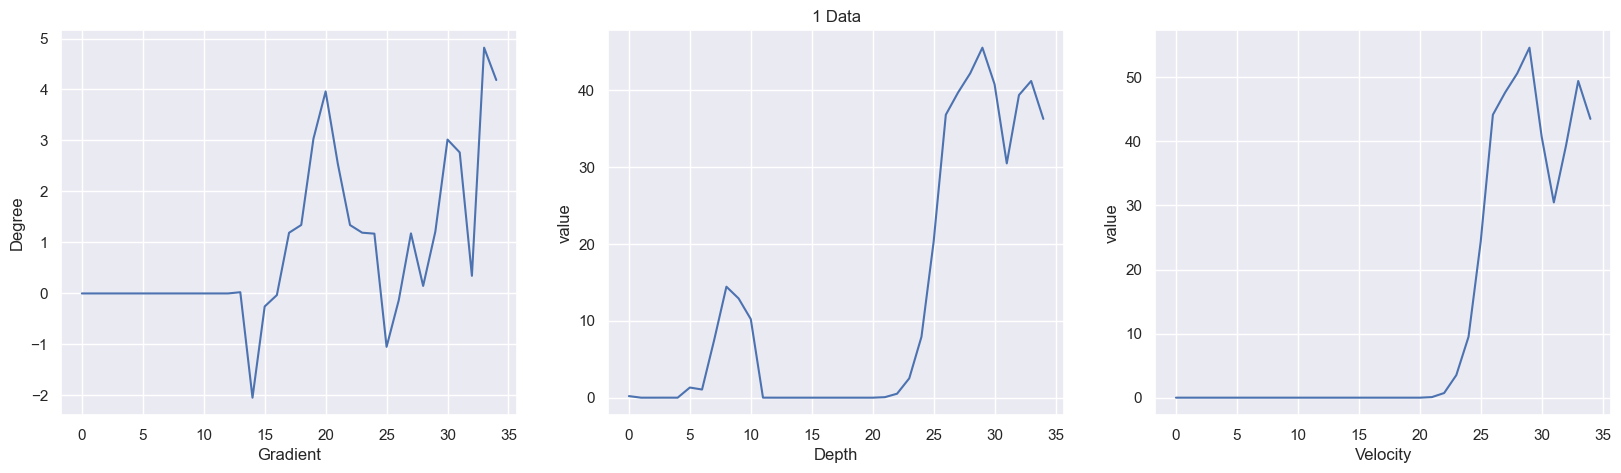

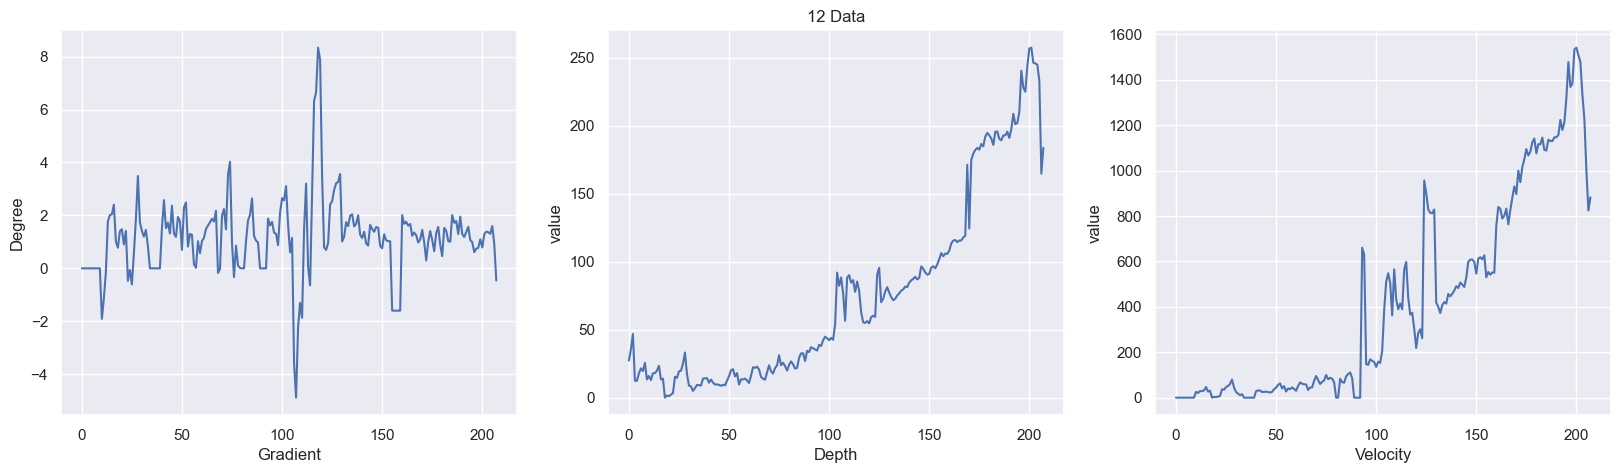

In [4]:
plot_infos(w_logs, figsize=(20, 5))

In [2]:
# Webcam
video = cv2.VideoCapture(0)

# Video information
fps = int(video.get(cv2.CAP_PROP_FPS))
w = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

#nframes = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

# GradAcc Parameters
sep = 1 # Sep param 
rate = 8 # Acc param
gap = 5 # Gap param
line_len = 50 # direction line length

# Initializing SORT Class
sort_tracker = Sort(max_age=5, min_hits=2, iou_threshold=0.2) 

# ZoeDepth Model preparation
zoe = torch.hub.load(".", "ZoeD_NK", source="local", pretrained=True)
zoe = zoe.to('cuda')

# BSUVNet Initialization
# Start Video Loader
vid_loader = videoLoader(
    0, 
    empty_bg=cfg.BSUVNet.emtpy_bg, 
    empty_win_len=cfg.BSUVNet.empty_win_len,
    empty_bg_path=cfg.BSUVNet.empty_bg_path,
    recent_bg=cfg.BSUVNet.recent_bg,
    seg_network=cfg.BSUVNet.seg_network,
    transforms_pre=cfg.BSUVNet.transforms_pre,
    transforms_post=cfg.BSUVNet.transforms_post
    )
tensor_loader = torch.utils.data.DataLoader(dataset=vid_loader, batch_size=1)

# Load BSUV-Net
bsuvnet = torch.load(cfg.BSUVNet.model_path)
bsuvnet.cuda().eval()

# Initialzing object for writing video output
#output = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'DIVX'),fps , (w,h))
#zoe_output = cv2.VideoWriter('zoe_output.mp4', cv2.VideoWriter_fourcc(*'DIVX'),fps , (w,h))
#mask_output = cv2.VideoWriter('mask_output.mp4', cv2.VideoWriter_fourcc(*'DIVX'),fps , (w,h))
torch.cuda.empty_cache()

# parameter
pre_status = None
dis_cnt = 0
mask_threshold = 10

# logging
w_logs = np.array([])
#grad_history = []
#depth_history = []
#vel_history = []
# Initializing model and setting it for inference
with torch.no_grad():
  # YOLOv7 Preparation
  weights, imgsz = opt['weights'], opt['img-size']
  set_logging()
  device = select_device(opt['device'])
  half = device.type != 'cpu'
  model = attempt_load(weights, map_location=device)  # load FP32 model
  stride = int(model.stride.max())  # model stride
  imgsz = check_img_size(imgsz, s=stride)  # check img_size
  if half:
    model.half()
  names = model.module.names if hasattr(model, 'module') else model.names
  #colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]
  if device.type != 'cpu':
    model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))
  classes = None
  if opt['classes']:
    classes = []
    for class_name in opt['classes']:
      classes.append(names.index(class_name))
  if classes:
    classes = [i for i in range(len(names)) if i not in classes]

  # Start
  #for j in tqdm(range(nframes)):
  while video.isOpened():
    for data in tensor_loader:
      t1 = time_synchronized()
      inp, img0 = data
      img0 = img0.squeeze().numpy()
      # Zoedepth write results
      zoe_img = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB) 
      zoe_img = Image.fromarray(zoe_img)  # transform cv2 to pil
      depth_pil = zoe.infer_pil(zoe_img, output_type="tensor")  # tensor image
      colored_depth = colorize(depth_pil)[:, :, :3] # Gray scale
      # BSUVNet write results
      bgs_pred = bsuvnet(inp.cuda().float()).cpu().numpy()[0, 0, :, :]
      fr = np.ones((h, w, 3)) * 0.5
      for ch in range(3):
        fr[:, :, ch] = bgs_pred
      fr = (fr * 255).astype(np.uint8) # Result [720, 1280, 3], all channel have the same value, gray scale
      # YOLO Prediction
      yolo_img = letterbox(img0, imgsz, stride=stride)[0]
      yolo_img = yolo_img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
      yolo_img = np.ascontiguousarray(yolo_img)
      yolo_img = torch.from_numpy(yolo_img).to(device)
      yolo_img = yolo_img.half() if half else yolo_img.float()  # uint8 to fp16/32
      yolo_img /= 255.0  # 0 - 255 to 0.0 - 1.0
      if yolo_img.ndimension() == 3:
        yolo_img = yolo_img.unsqueeze(0)

      # YOLOv7 Inference
      pred = model(yolo_img, augment= False)[0]
      pred = non_max_suppression(pred, opt['conf-thres'], opt['iou-thres'], classes= classes, agnostic= False)
        
      #########
      grads = []
      depths = []
      direcs = []
      vel = []
      # YOLO Unpacking Predictions
      for i, det in enumerate(pred):
        #s = ''
        #s += '%gx%g ' % yolo_img.shape[2:]  # print string
        #gn = torch.tensor(img0.shape)[[1, 0, 1, 0]]
        if len(det):
          det[:, :4] = scale_coords(yolo_img.shape[2:], det[:, :4], img0.shape).round()

          #for c in det[:, -1].unique():
            #n = (det[:, -1] == c).sum()  # detections per class
            #s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

          dets_to_sort = np.empty((0,6))

          # NOTE: We send in detected object class too
          for x1,y1,x2,y2,conf,detclass in det.cpu().detach().numpy():
            dets_to_sort = np.vstack((dets_to_sort, np.array([x1, y1, x2, y2, conf, detclass])))
            
          if opt['track']:
            tracked_dets = sort_tracker.update(dets_to_sort, opt['unique-track-color'])
            tracks = sort_tracker.getTrackers()

              # draw boxes for visualization
            if len(tracked_dets)>0:
                bbox_xyxy = tracked_dets[:,:4]
                identities = tracked_dets[:, 8]
                categories = tracked_dets[:, 4]
                confidences = None
                depths = compute_depth(colored_depth, bbox_xyxy)
                mask_bbox = find_contour_bbox(fr, threshold=mask_threshold)
                for t, track in enumerate(reversed(tracks)):
                  grad = 0
                  direc = None
                  grad, direc, pix_len = get_grad(track, img0, opt['thickness'], sep, rate, gap, line_len) # draw line w/ cal grad, pts
                  grads.append(grad * (180 / 3.14))
                  direcs.append(direc)
                  vel.append(depths[t if t < len(tracked_dets) else 0] * pix_len)
                #grad_history.append(grad)
                #vel_history.append(vel)
                #depth_history.append(depths)
          else:
            bbox_xyxy = dets_to_sort[:,:4]
            identities = None
            categories = dets_to_sort[:, 5]
            confidences = dets_to_sort[:, 4]

          img0, now_status, logs = identify_pedestrian_states(img0, bbox_xyxy, identities=identities, 
                                                        categories=categories, names=names, grads=grads,
                                                        depth=depths, mask=mask_bbox, direc=direcs, vel=vel,
                                                        undefined_threshold=0.1, grad_threshold=40, vel_threshold=900, 
                                                        x_values=[300, 800], depth_threshold=[[130, 140],[70, 100],[120, 160]],
                                                        img_sz=[w, h])
          pre_status, dis_cnt = maintain_sign(img0, now_status, pre_status, dis_cnt, img_sz=[w, h])
          w_logs = logging_infos(logs, datas=w_logs)
      output_img = np.hstack((colored_depth, fr, img0))
      t2 = time_synchronized()
      cv2.imshow('output.png', output_img)
      print("inference time : ", '{:.2f}'.format(t2 - t1), 'ms')
      if cv2.waitKey(1) == 27: # ESC
        print("KEY EXIT")
        break
    break
      
video.release()
cv2.destroyAllWindows()

img_size [384, 512]


Using cache found in C:\Users\gkstk/.cache\torch\hub\intel-isl_MiDaS_master
c:\Users\gkstk\anaconda3\envs\pawpularity\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_NK.pt
Loaded successfully
Empty background is completed


YOLOR  b394c39 torch 1.13.1 CUDA:cuda:0 (NVIDIA GeForce GTX 1080 Ti, 11263.75MB)



Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block


Model Summary: 306 layers, 36905341 parameters, 6652669 gradients


inference time :  1.91 ms
inference time :  0.60 ms
inference time :  0.59 ms
inference time :  0.58 ms
inference time :  0.57 ms
inference time :  0.57 ms
inference time :  0.57 ms
inference time :  0.57 ms


C:\Users\gkstk\AppData\Local\Temp\ipykernel_10216\3720637668.py:648: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  datas = np.array([np.array([log[0], np.array([log[1]]), np.array([log[2]]), np.array([log[3]]), np.array([log[4]])])])


inference time :  0.63 ms
inference time :  0.57 ms
inference time :  0.57 ms
inference time :  0.59 ms
inference time :  0.57 ms
inference time :  0.60 ms
inference time :  0.57 ms
inference time :  0.57 ms
inference time :  0.57 ms
KEY EXIT


In [2]:
# Webcam
video = cv2.VideoCapture(0)

# Video information
fps = int(video.get(cv2.CAP_PROP_FPS))
w = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
print("WEBCAM RESOLUTION = {} X {}".format(w, h))
#nframes = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

# GradAcc Parameters
sep = 1 # Sep param 
rate = 8 # Acc param
gap = 5 # Gap param
line_len = 50 # direction line length

# Initializing SORT Class
sort_tracker = Sort(max_age=5, min_hits=2, iou_threshold=0.2) 

# ZoeDepth Model preparation
zoe = torch.hub.load(".", "ZoeD_NK", source="local", pretrained=True)
zoe = zoe.to('cuda')

# BSUVNet Initialization
# Start Video Loader
vid_loader = videoLoader(
    0, 
    empty_bg=cfg.BSUVNet.emtpy_bg, 
    empty_win_len=cfg.BSUVNet.empty_win_len,
    empty_bg_path=cfg.BSUVNet.empty_bg_path,
    recent_bg=cfg.BSUVNet.recent_bg,
    seg_network=cfg.BSUVNet.seg_network,
    transforms_pre=cfg.BSUVNet.transforms_pre,
    transforms_post=cfg.BSUVNet.transforms_post
    )
tensor_loader = iter(torch.utils.data.DataLoader(dataset=vid_loader, batch_size=1))

# Load BSUV-Net
bsuvnet = torch.load(cfg.BSUVNet.model_path)
bsuvnet.cuda().eval()

# Initialzing object for writing video output
#output = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'DIVX'),fps , (w,h))
#zoe_output = cv2.VideoWriter('zoe_output.mp4', cv2.VideoWriter_fourcc(*'DIVX'),fps , (w,h))
#mask_output = cv2.VideoWriter('mask_output.mp4', cv2.VideoWriter_fourcc(*'DIVX'),fps , (w,h))
torch.cuda.empty_cache()

# parameter
pre_status = None
dis_cnt = 0
#mask_threshold = 10

# logging
w_logs = np.array([])
#grad_history = []
#depth_history = []
#vel_history = []
# Initializing model and setting it for inference
with torch.no_grad():
  # YOLOv7 Preparation
  weights, imgsz = opt['weights'], opt['img-size']
  set_logging()
  device = select_device(opt['device'])
  half = device.type != 'cpu'
  model = attempt_load(weights, map_location=device)  # load FP32 model
  stride = int(model.stride.max())  # model stride
  imgsz = check_img_size(imgsz, s=stride)  # check img_size
  if half:
    model.half()
  names = model.module.names if hasattr(model, 'module') else model.names
  colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]
  if device.type != 'cpu':
    model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))
  classes = None
  if opt['classes']:
    classes = []
    for class_name in opt['classes']:
      classes.append(names.index(class_name))
  if classes:
    classes = [i for i in range(len(names)) if i not in classes]
#for j in tqdm(range(nframes)):
def show_frame():
  with torch.no_grad():
    global image_id, image_id2, image_id3, pre_status, dis_cnt, w_logs, depths, mask_bbox  # inform function to assign new value to global variable instead of local variable
    data = next(tensor_loader)
    t1 = time_synchronized()
    inp, img0 = data
    img0 = img0.squeeze().numpy()
    # Zoedepth write results
    zoe_img = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB) 
    zoe_img = Image.fromarray(zoe_img)  # transform cv2 to pil
    depth_pil = zoe.infer_pil(zoe_img, output_type="tensor")  # tensor image
    colored_depth = colorize(depth_pil)[:, :, :3] # Gray scale
    # BSUVNet write results
    bgs_pred = bsuvnet(inp.cuda().float()).cpu().numpy()[0, 0, :, :]
    fr = np.ones((h, w, 3)) * 0.5
    for ch in range(3):
      fr[:, :, ch] = bgs_pred
    fr = (fr * 255).astype(np.uint8) # Result [720, 1280, 3], all channel have the same value, gray scale
    # YOLO Prediction
    yolo_img = letterbox(img0, imgsz, stride=stride)[0]
    yolo_img = yolo_img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
    yolo_img = np.ascontiguousarray(yolo_img)
    yolo_img = torch.from_numpy(yolo_img).to(device)
    yolo_img = yolo_img.half() if half else yolo_img.float()  # uint8 to fp16/32
    yolo_img /= 255.0  # 0 - 255 to 0.0 - 1.0
    if yolo_img.ndimension() == 3:
      yolo_img = yolo_img.unsqueeze(0)

    # YOLOv7 Inference
    pred = model(yolo_img, augment= False)[0]
    pred = non_max_suppression(pred, opt['conf-thres'], opt['iou-thres'], classes= classes, agnostic= False)
        
    #########
    grads = []
    depths = []
    direcs = []
    vel = []
    # YOLO Unpacking Predictions
    for i, det in enumerate(pred):
      #s = ''
      #s += '%gx%g ' % yolo_img.shape[2:]  # print string
      #gn = torch.tensor(img0.shape)[[1, 0, 1, 0]]
      if len(det):
        det[:, :4] = scale_coords(yolo_img.shape[2:], det[:, :4], img0.shape).round()

        #for c in det[:, -1].unique():
          #n = (det[:, -1] == c).sum()  # detections per class
          #s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

        dets_to_sort = np.empty((0,6))

        # NOTE: We send in detected object class too
        for x1,y1,x2,y2,conf,detclass in det.cpu().detach().numpy():
          dets_to_sort = np.vstack((dets_to_sort, np.array([x1, y1, x2, y2, conf, detclass])))
            
        if opt['track']:
          tracked_dets = sort_tracker.update(dets_to_sort, opt['unique-track-color'])
          tracks = sort_tracker.getTrackers()

          # draw boxes for visualization
          if len(tracked_dets)>0:
            bbox_xyxy = tracked_dets[:,:4]
            identities = tracked_dets[:, 8]
            categories = tracked_dets[:, 4]
            confidences = None
            depths = compute_depth(colored_depth, bbox_xyxy)
            mask_bbox = find_contour_bbox(fr, threshold=mask_threshold.get())
            for t, track in enumerate(reversed(tracks)):
              grad = 0
              direc = None
              grad, direc, pix_len = get_grad(track, img0, opt['thickness'], sep, rate, gap, line_len) # draw line w/ cal grad, pts
              grads.append(grad * (180 / 3.14))
              direcs.append(direc)
              vel.append(depths[t if t < len(tracked_dets) else 0] * pix_len)
            #grad_history.append(grad)
            #vel_history.append(vel)
            #depth_history.append(depths)
          else:
            bbox_xyxy = dets_to_sort[:,:4]
            identities = None
            categories = dets_to_sort[:, 5]
            confidences = dets_to_sort[:, 4]

          img0, now_status, logs = identify_pedestrian_states(img0, bbox_xyxy, identities=identities, 
                                                        categories=categories, names=names, grads=grads,
                                                        depth=depths, mask=mask_bbox, direc=direcs, vel=vel,
                                                        undefined_threshold=unknown_bbox_expansion_ratio.get(), grad_threshold=grad_threshold.get(), vel_threshold=vel_threshold.get(), 
                                                        x_values=[x_values1.get(), x_values2.get()], depth_threshold=[[depth_threshold1_1.get(), depth_threshold1_2.get()],
                                                        [depth_threshold2_1.get(), depth_threshold2_2.get()],[depth_threshold3_1.get(), depth_threshold3_2.get()]],
                                                        img_sz=[w, h])
          pre_status, dis_cnt = maintain_sign(img0, now_status, pre_status, dis_cnt, img_sz=[w, h])
          w_logs = logging_infos(logs, datas=w_logs)
    cv2.line(img0, (x_values1.get(), 0), (x_values1.get(), h), (150, 200, 150), 2)
    cv2.line(img0, (x_values2.get(), 0), (x_values2.get(), h), (0, 200, 0), 2)
    #output_img = np.hstack((colored_depth, fr, img0))
    output_img = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
    output_img = Image.fromarray(output_img)
    colored_depth = Image.fromarray(colored_depth)
    fr = Image.fromarray(fr)

    # convert to Tkinter image
    photo = ImageTk.PhotoImage(image=output_img)
    photo2 = ImageTk.PhotoImage(image=colored_depth)
    photo3 = ImageTk.PhotoImage(image=fr)
       
    # solution for bug in `PhotoImage`
    canvas.photo = photo
    canvas2.photo = photo2
    canvas3.photo = photo3

    # check if image already exists
    if image_id:       
      # replace image in PhotoImage on canvas
      canvas.itemconfig(image_id, image=photo)
    else:
      # create first image on canvas and keep its ID
      image_id = canvas.create_image((0, 0), image=photo, anchor='nw')
      # resize canvas
      canvas.configure(width=photo.width(), height=photo.height())
      # replace image in label
      #label.configure(image=photo)  

    if image_id2:       
      # replace image in PhotoImage on canvas
      canvas2.itemconfig(image_id2, image=photo2)
    else:
      # create first image on canvas and keep its ID
      image_id2 = canvas2.create_image((0, 0), image=photo2, anchor='nw')
      # resize canvas
      canvas2.configure(width=photo2.width(), height=photo2.height())
      # replace image in label
      #label.configure(image=photo)

    if image_id3:       
      # replace image in PhotoImage on canvas
      canvas3.itemconfig(image_id3, image=photo3)
    else:
      # create first image on canvas and keep its ID
      image_id3 = canvas3.create_image((0, 0), image=photo3, anchor='nw')
      # resize canvas
      canvas3.configure(width=photo3.width(), height=photo3.height())
      # replace image in label
      #label.configure(image=photo)
    # run again after 5ms
    t2 = time_synchronized()
    print("inference time : ", '{:.2f}'.format(t2 - t1 + 0.005), 's')
    window.after(5, show_frame)
    
# --- main ---
image_id = None # YOLO output
image_id2 = None # Depth output
image_id3 = None # BGS output

window = tk.Tk()
font1 = font.Font(family='Arial', weight='bold', size='20')
font2 = font.Font(family='Arial', weight='bold', size='10')
window.title("DETECTION")
window.geometry("{}x{}".format(w + 400, h))

# Set TkNotebook style
style = ttk.Style()

style.theme_create( "hsbtheme", parent="alt", settings={
        "TNotebook": {"configure": {"tabmargins": [2, 5, 2, 0], "background": 'lavender', "bd": 0}},
        "TNotebook.Tab": {
            "configure": {"padding": [15, 5], "background": 'light sky blue' , "foreground": "white", "font": font2, "bordercolor": 'lavender'},
            "map":       {"background": [("selected", 'lavender')],
                          "expand": [("selected", [1, 1, 1, 0])] } } } )

style.theme_use("hsbtheme")

# create a Label to display frames
label = tk.Label(window, text='Pedestrian Detection', anchor='s', width=1920, height=1, background='lavender', fg='white', font=font1)
label.pack()  # to resize label when resize window

frm1=tk.Frame(window, relief="solid", background='lavender')
frm1.pack(side="left", fill="both", expand=True)

frm2=tk.Frame(window, relief="solid", background='lavender')
frm2.pack(side="right", fill="both", expand=True)

frm1_1 = tk.Frame(frm1, relief="solid", background='lavender')
frm1_1.pack(side="left", fill="both", expand=True)

frm1_2 = tk.Frame(frm1, relief="solid", background='lavender')
frm1_2.pack(side="right", fill="both", expand=True)

# sliders
x_values1 = tk.Scale(frm1_1, label='x_values1', fg='white', from_=0, to=w, length=200, background='light sky blue', troughcolor='white', resolution=10, sliderrelief='flat', orient='horizontal', font=font2, relief='groove', bd=0)
x_values1.pack()
x_values1.set(300)

x_values2 = tk.Scale(frm1_2, label='x_values2', fg='white', from_=0, to=w, length=200, background='light sky blue', troughcolor='white', resolution=10, sliderrelief='flat', orient='horizontal', font=font2, bd=0)
x_values2.pack()
x_values2.set(w if 800 > w  else 800)

grad_threshold = tk.Scale(frm1_1, label='grad_threshold', fg='white', from_=0, to=90, length=200, background='light sky blue', troughcolor='white', resolution=5, sliderrelief='flat', orient='horizontal', font=font2, bd=0)
grad_threshold.pack()
grad_threshold.set(40)

vel_threshold = tk.Scale(frm1_2, label='vel_threshold', fg='white', from_=0, to=2000, length=200, background='light sky blue', troughcolor='white', resolution=100, sliderrelief='flat', orient='horizontal', font=font2, bd=0)
vel_threshold.pack()
vel_threshold.set(900)

mask_threshold = tk.Scale(frm1_1, label='mask_threshold', fg='white', from_=0, to=500, length=200, background='light sky blue', troughcolor='white', resolution=10, sliderrelief='flat', orient='horizontal', font=font2, bd=0)
mask_threshold.pack()
mask_threshold.set(10)

unknown_bbox_expansion_ratio = tk.Scale(frm1_2, label='unknown_bbox_expansion_ratio', fg='white', from_=0, to=1, length=200, background='light sky blue', troughcolor='white', resolution=0.05, sliderrelief='flat', orient='horizontal', font=font2, bd=0)
unknown_bbox_expansion_ratio.pack()
unknown_bbox_expansion_ratio.set(0.1)

depth_threshold1_1 = tk.Scale(frm1_1, label='depth_threshold1_1', fg='white', from_=0, to=255, length=200, background='light sky blue', troughcolor='white', resolution=5, sliderrelief='flat', orient='horizontal', font=font2, bd=0)
depth_threshold1_1.pack()
depth_threshold1_1.set(130)

depth_threshold1_2 = tk.Scale(frm1_2, label='depth_threshold1_2', fg='white', from_=0, to=255, length=200, background='light sky blue', troughcolor='white', resolution=5, sliderrelief='flat', orient='horizontal', font=font2, bd=0)
depth_threshold1_2.pack()
depth_threshold1_2.set(140)

depth_threshold2_1 = tk.Scale(frm1_1, label='depth_threshold2_1', fg='white', from_=0, to=255, length=200, background='light sky blue', troughcolor='white', resolution=5, sliderrelief='flat', orient='horizontal', font=font2, bd=0)
depth_threshold2_1.pack()
depth_threshold2_1.set(70)

depth_threshold2_2 = tk.Scale(frm1_2, label='depth_threshold2_2', fg='white', from_=0, to=255, length=200, background='light sky blue', troughcolor='white', resolution=5, sliderrelief='flat', orient='horizontal', font=font2, bd=0)
depth_threshold2_2.pack()
depth_threshold2_2.set(100)

depth_threshold3_1 = tk.Scale(frm1_1, label='depth_threshold3_1', fg='white', from_=0, to=255, length=200, background='light sky blue', troughcolor='white', resolution=5, sliderrelief='flat', orient='horizontal', font=font2, bd=0)
depth_threshold3_1.pack()
depth_threshold3_1.set(120)

depth_threshold3_2 = tk.Scale(frm1_2, label='depth_threshold3_2', fg='white', from_=0, to=255, length=200, background='light sky blue', troughcolor='white', resolution=5, sliderrelief='flat', orient='horizontal', font=font2, bd=0)
depth_threshold3_2.pack()
depth_threshold3_2.set(160)

# create notebook
notebook = ttk.Notebook(frm2, width=w, height=h)
notebook.pack()

frame1=tk.Frame(window)
notebook.add(frame1, text="YOLO")

canvas = tk.Canvas(frame1, width=w, height=h, relief="flat", bg='white')
canvas.pack(fill='both', expand=True)

frame2=tk.Frame(window)
notebook.add(frame2, text="Depth")

canvas2 = tk.Canvas(frame2, width=w, height=h, relief="flat", bg='white')
canvas2.pack(fill='both', expand=True)

frame3=tk.Frame(window)
notebook.add(frame3, text="BGS")

canvas3 = tk.Canvas(frame3, width=w, height=h, relief="flat", bg='white')
canvas3.pack(fill='both', expand=True)

notebook.pack(expand=1, fill='both', padx=5, pady=5)

# start function which shows frame
show_frame()
window.mainloop()
video.release()

WEBCAM RESOLUTION = 640 X 480
img_size [384, 512]


Using cache found in C:\Users\gkstk/.cache\torch\hub\intel-isl_MiDaS_master
c:\Users\gkstk\anaconda3\envs\pawpularity\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_NK.pt
Loaded successfully
Empty background is completed


YOLOR  b394c39 torch 1.13.1 CUDA:cuda:0 (NVIDIA GeForce GTX 1080 Ti, 11263.75MB)



Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block


Model Summary: 306 layers, 36905341 parameters, 6652669 gradients
C:\Users\gkstk\AppData\Local\Temp\ipykernel_5176\1997303898.py:653: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  datas = np.array([np.array([log[0], np.array([log[1]]), np.array([log[2]]), np.array([log[3]]), np.array([log[4]])])])


inference time :  2.08 s


c:\Users\gkstk\anaconda3\envs\pawpularity\lib\site-packages\numpy\core\shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


inference time :  0.65 s
inference time :  0.61 s
inference time :  0.62 s
inference time :  0.60 s
inference time :  0.63 s
inference time :  0.63 s
inference time :  0.60 s
inference time :  0.60 s
inference time :  0.60 s
inference time :  0.60 s
inference time :  0.61 s
inference time :  0.60 s
inference time :  0.60 s
inference time :  0.60 s
inference time :  0.61 s
inference time :  0.61 s
inference time :  0.61 s
inference time :  0.61 s
inference time :  0.61 s
inference time :  0.61 s
inference time :  0.61 s
inference time :  0.61 s
inference time :  0.61 s
